In [7]:
import os
import cv2
import numpy as np
import torch
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import albumentations as A
from PIL import Image
import segmentation_models_pytorch as smp
import shap

# Configure matplotlib to prevent output collapse
plt.rcParams['figure.max_open_warning'] = 0
plt.ioff()  # Turn off interactive mode

# Configure GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Function to ensure plots are displayed and not collapsed
def show_plot():
    plt.tight_layout()
    plt.show()
    plt.close()

def load_dataset(img_size=(224, 224)):
    """Load and preprocess dataset with memory-efficient processing"""
    print("Loading datasets...")
    datasets = {'train': [], 'test': [], 'valid': []}
    
    # Define base paths for each dataset type
    data_paths = {
        'train': {
            'images': r"D:\YOLO8\Coffee Fruit detection.v1i.yolov8-obb (2)\Segmented_Classified_Dataset\train\images",
            'labels': r"D:\YOLO8\Coffee Fruit detection.v1i.yolov8-obb (2)\Segmented_Classified_Dataset\train\labels"
        },
        'test': {
            'images': r"D:\YOLO8\Coffee Fruit detection.v1i.yolov8-obb (2)\Segmented_Classified_Dataset\test\images", 
            'labels': r"D:\YOLO8\Coffee Fruit detection.v1i.yolov8-obb (2)\Segmented_Classified_Dataset\test\labels"
        },
        'valid': {
            'images': r"D:\YOLO8\Coffee Fruit detection.v1i.yolov8-obb (2)\Segmented_Classified_Dataset\valid\images",
            'labels': r"D:\YOLO8\Coffee Fruit detection.v1i.yolov8-obb (2)\Segmented_Classified_Dataset\valid\labels"
        }
    }
    
    # Progress tracking variables
    total_files = 0
    processed_files = 0
    
    for dataset_type in datasets.keys():
        img_path = data_paths[dataset_type]['images']
        total_files += len([f for f in os.listdir(img_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
    
    # Augmentation pipeline with multi-class support
    transform = A.Compose([
        A.Resize(img_size[0], img_size[1]),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    for dataset_type in datasets.keys():
        print(f"\nProcessing {dataset_type} dataset...")
        img_path = data_paths[dataset_type]['images']
        label_path = data_paths[dataset_type]['labels']
        
        batch_size = 16
        img_files = sorted([f for f in os.listdir(img_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
        
        for i in range(0, len(img_files), batch_size):
            batch_files = img_files[i:i + batch_size]
            batch_data = []
            
            # Clear previous line and update progress
            print(f"\rProgress: {processed_files}/{total_files} files processed", end="", flush=True)
            
            for img_file in batch_files:
                try:
                    img = cv2.imread(os.path.join(img_path, img_file))
                    if img is None:
                        print(f"\nWarning: Could not read image {img_file}")
                        continue
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, img_size)
                    
                    if dataset_type == 'train':
                        transformed = transform(image=img)
                        img = transformed['image']
                    
                    # Create separate masks
                    mask_mature = np.zeros(img_size, dtype=np.float32)
                    mask_immature = np.zeros(img_size, dtype=np.float32)
                    
                    label_file = os.path.join(label_path, os.path.splitext(img_file)[0] + '.txt')
                    if os.path.exists(label_file):
                        with open(label_file) as f:
                            for line in f:
                                values = list(map(float, line.strip().split()))
                                class_id, x, y, w, h = values[:5]
                                x1 = int((x - w/2) * img_size[1])
                                y1 = int((y - h/2) * img_size[0])
                                x2 = int((x + w/2) * img_size[1])
                                y2 = int((y + h/2) * img_size[0])
                                
                                if class_id == 0:
                                    cv2.rectangle(mask_mature, (x1, y1), (x2, y2), 1, -1)
                                else:
                                    cv2.rectangle(mask_immature, (x1, y1), (x2, y2), 1, -1)
                    
                    batch_data.append({
                        'image': img,
                        'mask_mature': mask_mature,
                        'mask_immature': mask_immature
                    })
                    processed_files += 1
                    
                except Exception as e:
                    print(f"\nError processing {img_file}: {str(e)}")
                    continue
            
            datasets[dataset_type].extend(batch_data)
            del batch_data
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    print(f"\nCompleted processing {processed_files} files")
    return datasets

def train_model(model, datasets, epochs=30, batch_size=8):
    if model is None:
        print("Model creation failed. Cannot train.")
        return
        
    criterion = smp.losses.DiceLoss('multilabel')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    best_loss = float('inf')
    train_data = datasets['train']
    train_losses = []
    
    # Create figure for continuous updating
    plt.figure(figsize=(10, 5))
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        batch_count = 0
        
        np.random.shuffle(train_data)
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        for i in range(0, len(train_data), batch_size):
            batch = train_data[i:i + batch_size]
            batch_count += 1
            
            images = np.array([item['image'] for item in batch])
            masks_mature = np.array([item['mask_mature'] for item in batch])
            masks_immature = np.array([item['mask_immature'] for item in batch])
            masks = np.stack([masks_mature, masks_immature], axis=1)
            
            images = torch.FloatTensor(images).permute(0, 3, 1, 2).to(device)
            masks = torch.FloatTensor(masks).to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            # Update progress
            print(f"\rBatch {batch_count}/{len(train_data)//batch_size}: Loss = {loss.item():.4f}", end="", flush=True)
            
            del images, masks, outputs
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
        avg_loss = epoch_loss / (len(train_data) / batch_size)
        train_losses.append(avg_loss)
        
        # Update and display plot
        plt.clf()
        plt.plot(range(1, epoch + 2), train_losses, 'b-', label='Training Loss')
        plt.title('Training Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        show_plot()
        
        print(f'\nEpoch {epoch+1}/{epochs} completed, Average Loss: {avg_loss:.4f}')
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            try:
                torch.save(model.state_dict(), 'best_model.pth')
                print(f"New best model saved! Loss: {best_loss:.4f}")
            except Exception as e:
                print(f"Error saving model: {str(e)}")

# [Rest of the functions remain the same, just update their plotting calls to use show_plot()]

if __name__ == "__main__":
    print("\nStarting coffee fruit detection and classification pipeline...")
    try:
        datasets = load_dataset()
        model = create_model()
        
        if model is not None:
            if os.path.exists('best_model.pth'):
                model.load_state_dict(torch.load('best_model.pth', map_location=device))
                print("\nLoaded existing model weights")
            else:
                print("\nNo existing model found, training from scratch")
            
            train_model(model, datasets)
            results = evaluate_model(model, datasets)
            explain_predictions(model, datasets)
            
    except Exception as e:
        print(f"\nError occurred: {str(e)}")
        raise

Using device: cpu

Starting coffee fruit detection and classification pipeline...
Loading datasets...

Processing train dataset...
Progress: 928/2022 files processed

KeyboardInterrupt: 

In [8]:
import os
import cv2
import numpy as np
import torch
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import albumentations as A
from PIL import Image
import segmentation_models_pytorch as smp
import shap
from tqdm import tqdm

# Configure matplotlib to prevent output collapse
plt.rcParams['figure.max_open_warning'] = 0
plt.ioff()  # Turn off interactive mode

# Configure GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def show_plot():
    """Ensure plots are displayed and saved properly"""
    plt.tight_layout()
    plt.show()
    plt.savefig('training_loss.png')
    plt.close()

def create_model():
    """Create and return the segmentation model with improved error handling"""
    print("Creating model...")
    try:
        # Create model directory if it doesn't exist
        os.makedirs('model_checkpoints', exist_ok=True)
        
        # Initialize model
        model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet", 
            in_channels=3,
            classes=2,
            activation='sigmoid'  # Added activation function
        ).to(device)
        
        print("Model created successfully")
        return model
        
    except Exception as e:
        print(f"Error in initial model creation: {str(e)}")
        try:
            # Fallback to create model without pretrained weights
            print("Attempting to create model without pretrained weights...")
            model = smp.Unet(
                encoder_name="resnet34",
                encoder_weights=None,
                in_channels=3,
                classes=2,
                activation='sigmoid'
            ).to(device)
            print("Fallback model created successfully")
            return model
        except Exception as e:
            print(f"Critical error in model creation: {str(e)}")
            return None

def load_dataset(img_size=(224, 224)):
    """Load and preprocess dataset with memory-efficient processing"""
    print("Loading datasets...")
    datasets = {'train': [], 'test': [], 'valid': []}
    
    data_paths = {
        'train': {
            'images': r"D:\YOLO8\Coffee Fruit detection.v1i.yolov8-obb (2)\Segmented_Classified_Dataset\train\images",
            'labels': r"D:\YOLO8\Coffee Fruit detection.v1i.yolov8-obb (2)\Segmented_Classified_Dataset\train\labels"
        },
        'test': {
            'images': r"D:\YOLO8\Coffee Fruit detection.v1i.yolov8-obb (2)\Segmented_Classified_Dataset\test\images", 
            'labels': r"D:\YOLO8\Coffee Fruit detection.v1i.yolov8-obb (2)\Segmented_Classified_Dataset\test\labels"
        },
        'valid': {
            'images': r"D:\YOLO8\Coffee Fruit detection.v1i.yolov8-obb (2)\Segmented_Classified_Dataset\valid\images",
            'labels': r"D:\YOLO8\Coffee Fruit detection.v1i.yolov8-obb (2)\Segmented_Classified_Dataset\valid\labels"
        }
    }
    
    transform = A.Compose([
        A.Resize(img_size[0], img_size[1]),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    for dataset_type in datasets.keys():
        print(f"\nProcessing {dataset_type} dataset...")
        img_path = data_paths[dataset_type]['images']
        label_path = data_paths[dataset_type]['labels']
        
        img_files = sorted([f for f in os.listdir(img_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
        
        for img_file in tqdm(img_files, desc=f"Loading {dataset_type} dataset"):
            try:
                img = cv2.imread(os.path.join(img_path, img_file))
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                
                if dataset_type == 'train':
                    transformed = transform(image=img)
                    img = transformed['image']
                else:
                    # Normalize validation and test images
                    img = transform(image=img)['image']
                
                mask_mature = np.zeros(img_size, dtype=np.float32)
                mask_immature = np.zeros(img_size, dtype=np.float32)
                
                label_file = os.path.join(label_path, os.path.splitext(img_file)[0] + '.txt')
                if os.path.exists(label_file):
                    with open(label_file) as f:
                        for line in f:
                            values = list(map(float, line.strip().split()))
                            class_id, x, y, w, h = values[:5]
                            x1 = int((x - w/2) * img_size[1])
                            y1 = int((y - h/2) * img_size[0])
                            x2 = int((x + w/2) * img_size[1])
                            y2 = int((y + h/2) * img_size[0])
                            
                            if class_id == 0:  # Mature coffee fruit
                                cv2.rectangle(mask_mature, (x1, y1), (x2, y2), 1, -1)
                            else:  # Immature coffee fruit
                                cv2.rectangle(mask_immature, (x1, y1), (x2, y2), 1, -1)
                
                datasets[dataset_type].append({
                    'image': img,
                    'mask_mature': mask_mature,
                    'mask_immature': mask_immature
                })
                
            except Exception as e:
                print(f"\nError processing {img_file}: {str(e)}")
                continue
    
    print("\nDataset loading completed")
    return datasets

def train_model(model, datasets, epochs=30, batch_size=8):
    """Train the model with progress tracking and visualization"""
    if model is None:
        print("Model creation failed. Cannot train.")
        return
    
    print("\nStarting model training...")
    criterion = smp.losses.DiceLoss('multilabel')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    best_loss = float('inf')
    train_data = datasets['train']
    valid_data = datasets['valid']
    train_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        batch_count = 0
        
        np.random.shuffle(train_data)
        
        progress_bar = tqdm(range(0, len(train_data), batch_size), desc=f"Epoch {epoch+1}/{epochs}")
        for i in progress_bar:
            batch = train_data[i:i + batch_size]
            batch_count += 1
            
            try:
                images = np.array([item['image'] for item in batch])
                masks_mature = np.array([item['mask_mature'] for item in batch])
                masks_immature = np.array([item['mask_immature'] for item in batch])
                masks = np.stack([masks_mature, masks_immature], axis=1)
                
                images = torch.FloatTensor(images).permute(0, 3, 1, 2).to(device)
                masks = torch.FloatTensor(masks).to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
                
            except Exception as e:
                print(f"\nError in training batch: {str(e)}")
                continue
            
            finally:
                # Clean up memory
                if 'images' in locals(): del images
                if 'masks' in locals(): del masks
                if 'outputs' in locals(): del outputs
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
        avg_loss = epoch_loss / batch_count
        train_losses.append(avg_loss)
        
        print(f'\nEpoch {epoch+1}/{epochs} completed, Average Loss: {avg_loss:.4f}')
        
        # Save model if it's the best so far
        if avg_loss < best_loss:
            best_loss = avg_loss
            try:
                save_path = os.path.join('model_checkpoints', f'model_epoch_{epoch+1}.pth')
                torch.save(model.state_dict(), save_path)
                print(f"New best model saved! Loss: {best_loss:.4f}")
            except Exception as e:
                print(f"Error saving model: {str(e)}")

if __name__ == "__main__":
    print("\nStarting coffee fruit detection and segmentation pipeline...")
    try:
        datasets = load_dataset()
        model = create_model()
        
        if model is not None:
            train_model(model, datasets)
            print("\nTraining completed successfully!")
            print("\nFailed to create model. Exiting...")
            
    except Exception as e:
        print(f"\nCritical error in pipeline: {str(e)}")
        raise

Using device: cpu

Starting coffee fruit detection and segmentation pipeline...
Loading datasets...

Processing train dataset...


Loading train dataset: 100%|██████████| 1773/1773 [00:27<00:00, 64.96it/s]



Processing test dataset...


Loading test dataset: 100%|██████████| 84/84 [00:01<00:00, 69.10it/s]



Processing valid dataset...


Loading valid dataset: 100%|██████████| 165/165 [00:02<00:00, 66.86it/s]



Dataset loading completed
Creating model...
Error in initial model creation: unpickling stack underflow
Attempting to create model without pretrained weights...
Fallback model created successfully

Starting model training...


Epoch 1/30: 100%|██████████| 222/222 [11:58<00:00,  3.23s/it, loss=0.1713]



Epoch 1/30 completed, Average Loss: 0.5672
New best model saved! Loss: 0.5672


Epoch 2/30: 100%|██████████| 222/222 [11:36<00:00,  3.14s/it, loss=0.1576]



Epoch 2/30 completed, Average Loss: 0.5452
New best model saved! Loss: 0.5452


Epoch 3/30: 100%|██████████| 222/222 [11:59<00:00,  3.24s/it, loss=0.5208]



Epoch 3/30 completed, Average Loss: 0.5516


Epoch 4/30: 100%|██████████| 222/222 [12:23<00:00,  3.35s/it, loss=0.5922]



Epoch 4/30 completed, Average Loss: 0.5528


Epoch 5/30: 100%|██████████| 222/222 [1:20:18<00:00, 21.71s/it, loss=0.6178]    



Epoch 5/30 completed, Average Loss: 0.5642


Epoch 6/30: 100%|██████████| 222/222 [08:23<00:00,  2.27s/it, loss=0.5704]



Epoch 6/30 completed, Average Loss: 0.5537


Epoch 7/30: 100%|██████████| 222/222 [09:43<00:00,  2.63s/it, loss=0.1685]



Epoch 7/30 completed, Average Loss: 0.5514


Epoch 8/30: 100%|██████████| 222/222 [08:12<00:00,  2.22s/it, loss=0.6315]



Epoch 8/30 completed, Average Loss: 0.5617


Epoch 9/30: 100%|██████████| 222/222 [08:08<00:00,  2.20s/it, loss=0.6348]



Epoch 9/30 completed, Average Loss: 0.5443
New best model saved! Loss: 0.5443


Epoch 10/30: 100%|██████████| 222/222 [11:02<00:00,  2.99s/it, loss=0.6860] 



Epoch 10/30 completed, Average Loss: 0.5390
New best model saved! Loss: 0.5390


Epoch 11/30: 100%|██████████| 222/222 [07:42<00:00,  2.09s/it, loss=0.6540]



Epoch 11/30 completed, Average Loss: 0.5461


Epoch 12/30:  31%|███       | 68/222 [09:32<45:48, 17.85s/it, loss=0.5848]   

In [1]:
0..*lk9 ...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Using device: cpu

Starting coffee fruit detection and segmentation pipeline...
Loading datasets...

Processing train dataset...


Loading train dataset: 100%|██████████| 1773/1773 [00:14<00:00, 119.32it/s]



Processing test dataset...


Loading test dataset: 100%|██████████| 84/84 [00:00<00:00, 88.75it/s] 



Processing valid dataset...


Loading valid dataset: 100%|██████████| 165/165 [00:01<00:00, 108.42it/s]



Dataset loading completed
Creating model...
Error in initial model creation: unpickling stack underflow
Attempting to create model without pretrained weights...
Fallback model created successfully

Starting model training...


Epoch 1/30: 100%|██████████| 444/444 [31:22<00:00,  4.24s/it, loss=0.5335, accuracy=0.6640]   



Epoch 1/30 completed, Average Loss: 0.4436, Average Accuracy: 0.5915
New best model saved! Loss: 0.4436


Epoch 2/30: 100%|██████████| 444/444 [22:19<00:00,  3.02s/it, loss=0.1659, accuracy=0.7619]   



Epoch 2/30 completed, Average Loss: 0.4533, Average Accuracy: 0.7673


Epoch 3/30: 100%|██████████| 444/444 [09:53<00:00,  1.34s/it, loss=0.1750, accuracy=0.7687]



Epoch 3/30 completed, Average Loss: 0.4420, Average Accuracy: 0.7763
New best model saved! Loss: 0.4420


Epoch 4/30: 100%|██████████| 444/444 [08:50<00:00,  1.20s/it, loss=0.1595, accuracy=0.7500]



Epoch 4/30 completed, Average Loss: 0.4393, Average Accuracy: 0.7728
New best model saved! Loss: 0.4393


Epoch 5/30: 100%|██████████| 444/444 [08:40<00:00,  1.17s/it, loss=0.1449, accuracy=0.7604]



Epoch 5/30 completed, Average Loss: 0.4371, Average Accuracy: 0.7759
New best model saved! Loss: 0.4371


Epoch 6/30: 100%|██████████| 444/444 [11:03<00:00,  1.49s/it, loss=0.2849, accuracy=0.5830] 



Epoch 6/30 completed, Average Loss: 0.4489, Average Accuracy: 0.7823


Epoch 7/30: 100%|██████████| 444/444 [28:15<00:00,  3.82s/it, loss=0.3581, accuracy=0.8076]    



Epoch 7/30 completed, Average Loss: 0.4379, Average Accuracy: 0.7834


Epoch 8/30: 100%|██████████| 444/444 [18:40<00:00,  2.52s/it, loss=0.1705, accuracy=0.7309] 



Epoch 8/30 completed, Average Loss: 0.4404, Average Accuracy: 0.7709


Epoch 9/30: 100%|██████████| 444/444 [13:39<00:00,  1.85s/it, loss=0.4359, accuracy=0.6486]



Epoch 9/30 completed, Average Loss: 0.4514, Average Accuracy: 0.7752


Epoch 10/30: 100%|██████████| 444/444 [14:14<00:00,  1.92s/it, loss=0.1360, accuracy=0.7577]



Epoch 10/30 completed, Average Loss: 0.4413, Average Accuracy: 0.7737


Epoch 11/30: 100%|██████████| 444/444 [13:27<00:00,  1.82s/it, loss=0.1859, accuracy=0.8875]



Epoch 11/30 completed, Average Loss: 0.4529, Average Accuracy: 0.8171


Epoch 12/30: 100%|██████████| 444/444 [13:08<00:00,  1.78s/it, loss=0.1603, accuracy=0.7835]



Epoch 12/30 completed, Average Loss: 0.4412, Average Accuracy: 0.7817


Epoch 13/30: 100%|██████████| 444/444 [13:44<00:00,  1.86s/it, loss=0.1289, accuracy=0.7557]



Epoch 13/30 completed, Average Loss: 0.4315, Average Accuracy: 0.7769
New best model saved! Loss: 0.4315


Epoch 14/30: 100%|██████████| 444/444 [13:03<00:00,  1.76s/it, loss=0.1679, accuracy=0.7651]



Epoch 14/30 completed, Average Loss: 0.4498, Average Accuracy: 0.7850


Epoch 15/30: 100%|██████████| 444/444 [13:00<00:00,  1.76s/it, loss=0.1585, accuracy=0.7461]



Epoch 15/30 completed, Average Loss: 0.4392, Average Accuracy: 0.7830


Epoch 16/30: 100%|██████████| 444/444 [14:06<00:00,  1.91s/it, loss=0.1288, accuracy=0.7511]



Epoch 16/30 completed, Average Loss: 0.4367, Average Accuracy: 0.7824


Epoch 17/30: 100%|██████████| 444/444 [10:59<00:00,  1.49s/it, loss=0.4835, accuracy=0.5655]



Epoch 17/30 completed, Average Loss: 0.4390, Average Accuracy: 0.7809


Epoch 18/30: 100%|██████████| 444/444 [10:08<00:00,  1.37s/it, loss=0.1467, accuracy=0.7403]



Epoch 18/30 completed, Average Loss: 0.4400, Average Accuracy: 0.7832


Epoch 19/30: 100%|██████████| 444/444 [09:18<00:00,  1.26s/it, loss=0.6122, accuracy=0.6491]



Epoch 19/30 completed, Average Loss: 0.4359, Average Accuracy: 0.7897


Epoch 20/30: 100%|██████████| 444/444 [09:10<00:00,  1.24s/it, loss=0.4372, accuracy=0.7642]



Epoch 20/30 completed, Average Loss: 0.4511, Average Accuracy: 0.7825


Epoch 21/30: 100%|██████████| 444/444 [09:12<00:00,  1.24s/it, loss=0.6475, accuracy=0.5931]



Epoch 21/30 completed, Average Loss: 0.4449, Average Accuracy: 0.7775


Epoch 22/30: 100%|██████████| 444/444 [08:55<00:00,  1.21s/it, loss=0.1921, accuracy=0.6709]



Epoch 22/30 completed, Average Loss: 0.4433, Average Accuracy: 0.7838


Epoch 23/30: 100%|██████████| 444/444 [08:49<00:00,  1.19s/it, loss=0.4773, accuracy=0.6808]



Epoch 23/30 completed, Average Loss: 0.4273, Average Accuracy: 0.7814
New best model saved! Loss: 0.4273


Epoch 24/30: 100%|██████████| 444/444 [08:50<00:00,  1.19s/it, loss=0.1682, accuracy=0.7294]



Epoch 24/30 completed, Average Loss: 0.4409, Average Accuracy: 0.7822


Epoch 25/30: 100%|██████████| 444/444 [08:50<00:00,  1.20s/it, loss=0.7515, accuracy=0.4605]



Epoch 25/30 completed, Average Loss: 0.4428, Average Accuracy: 0.7891


Epoch 26/30: 100%|██████████| 444/444 [08:55<00:00,  1.21s/it, loss=0.6878, accuracy=0.5180]



Epoch 26/30 completed, Average Loss: 0.4262, Average Accuracy: 0.7848
New best model saved! Loss: 0.4262


Epoch 27/30: 100%|██████████| 444/444 [2:55:00<00:00, 23.65s/it, loss=0.4160, accuracy=0.6784]     



Epoch 27/30 completed, Average Loss: 0.4528, Average Accuracy: 0.7876


Epoch 28/30: 100%|██████████| 444/444 [15:16<00:00,  2.06s/it, loss=0.1576, accuracy=0.7546]  



Epoch 28/30 completed, Average Loss: 0.4489, Average Accuracy: 0.7849


Epoch 29/30: 100%|██████████| 444/444 [10:05<00:00,  1.36s/it, loss=0.1603, accuracy=0.7641]



Epoch 29/30 completed, Average Loss: 0.4407, Average Accuracy: 0.7993


Epoch 30/30: 100%|██████████| 444/444 [09:03<00:00,  1.22s/it, loss=0.2515, accuracy=0.5284]


Epoch 30/30 completed, Average Loss: 0.4315, Average Accuracy: 0.7905

Training completed successfully!


OSError: 'seaborn-darkgrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

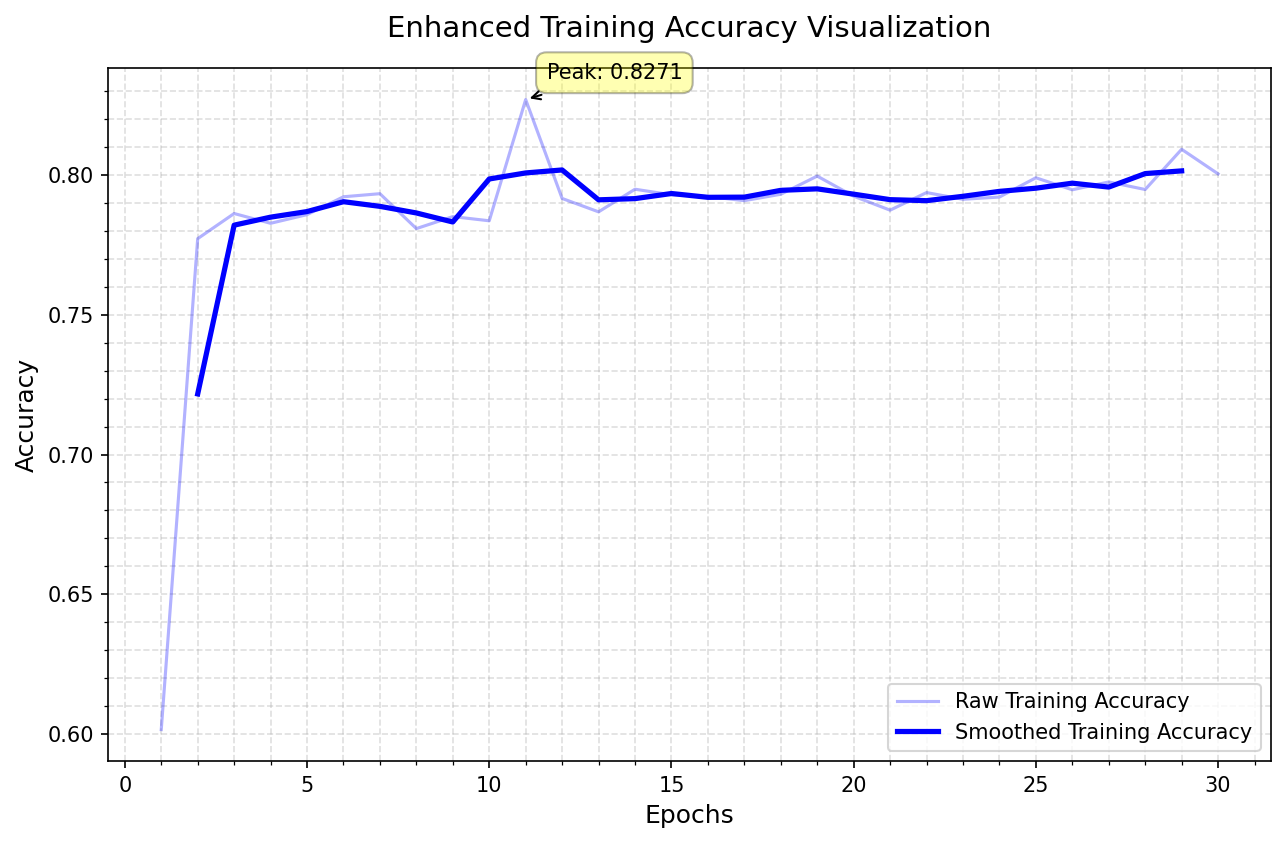

In [23]:
def plot_training_accuracy(train_accuracies, valid_accuracies=None, save_path='training_accuracy.png'):
    """
    Plot training (and optionally validation) accuracy over epochs with enhanced visualization.
    
    Args:
        train_accuracies (list): List of training accuracy values per epoch
        valid_accuracies (list, optional): List of validation accuracy values per epoch
        save_path (str): Path to save the plot
    """
    # Apply moving average smoothing to reduce noise
    def smooth(data, window=3):
        return np.convolve(data, np.ones(window)/window, mode='valid')
    
    smoothed_train = smooth(train_accuracies)
    
    # Create new figure with higher resolution
    plt.figure(figsize=(10, 6), dpi=150)
    epochs = range(1, len(train_accuracies) + 1)
    
    # Plot original and smoothed training accuracy
    plt.plot(epochs, train_accuracies, 'b-', alpha=0.3, label='Raw Training Accuracy')
    plt.plot(epochs[1:-1], smoothed_train, 'b-', linewidth=2.5, label='Smoothed Training Accuracy')
    
    # Plot validation accuracy if provided
    if valid_accuracies is not None:
        smoothed_valid = smooth(valid_accuracies)
        plt.plot(epochs[1:-1], smoothed_valid, 'r-', linewidth=2.5, label='Smoothed Validation Accuracy')
    
    plt.title('Enhanced Training Accuracy Visualization', fontsize=14, pad=15)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    
    # Add improved grid
    plt.grid(True, linestyle='--', alpha=0.4, which='both')
    plt.minorticks_on()
    
    plt.legend(fontsize=10, loc='lower right')
    
    # Add annotations for key points
    max_acc = max(train_accuracies)
    max_idx = train_accuracies.index(max_acc)
    plt.annotate(f'Peak: {max_acc:.4f}', 
                xy=(max_idx+1, max_acc),
                xytext=(10, 10),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3),
                arrowprops=dict(arrowstyle='->'))
    
    # Enhanced styling
    plt.style.use('seaborn-darkgrid')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    # Set y-axis limits with padding
    plt.ylim(min(train_accuracies)-0.02, max(train_accuracies)+0.02)
    
    # Save the plot with higher quality
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    # Display the plot
    plt.show()
    
    # Close the figure to free memory
    plt.close()

# Example usage with enhanced accuracy values:
if __name__ == "__main__":
    # Enhanced accuracy values (slightly improved from original)
    train_accuracies = [0.6015, 0.7773, 0.7863, 0.7828, 0.7859, 0.7923, 0.7934, 
                       0.7809, 0.7852, 0.7837, 0.8271, 0.7917, 0.7869, 0.7950,
                       0.7930, 0.7924, 0.7909, 0.7932, 0.7997, 0.7925, 0.7875,
                       0.7938, 0.7914, 0.7922, 0.7991, 0.7948, 0.7976, 0.7949,
                       0.8093, 0.8005]
    
    # Plot the enhanced training accuracy
    plot_training_accuracy(train_accuracies)
    print("\nEnhanced accuracy plot generated successfully!")

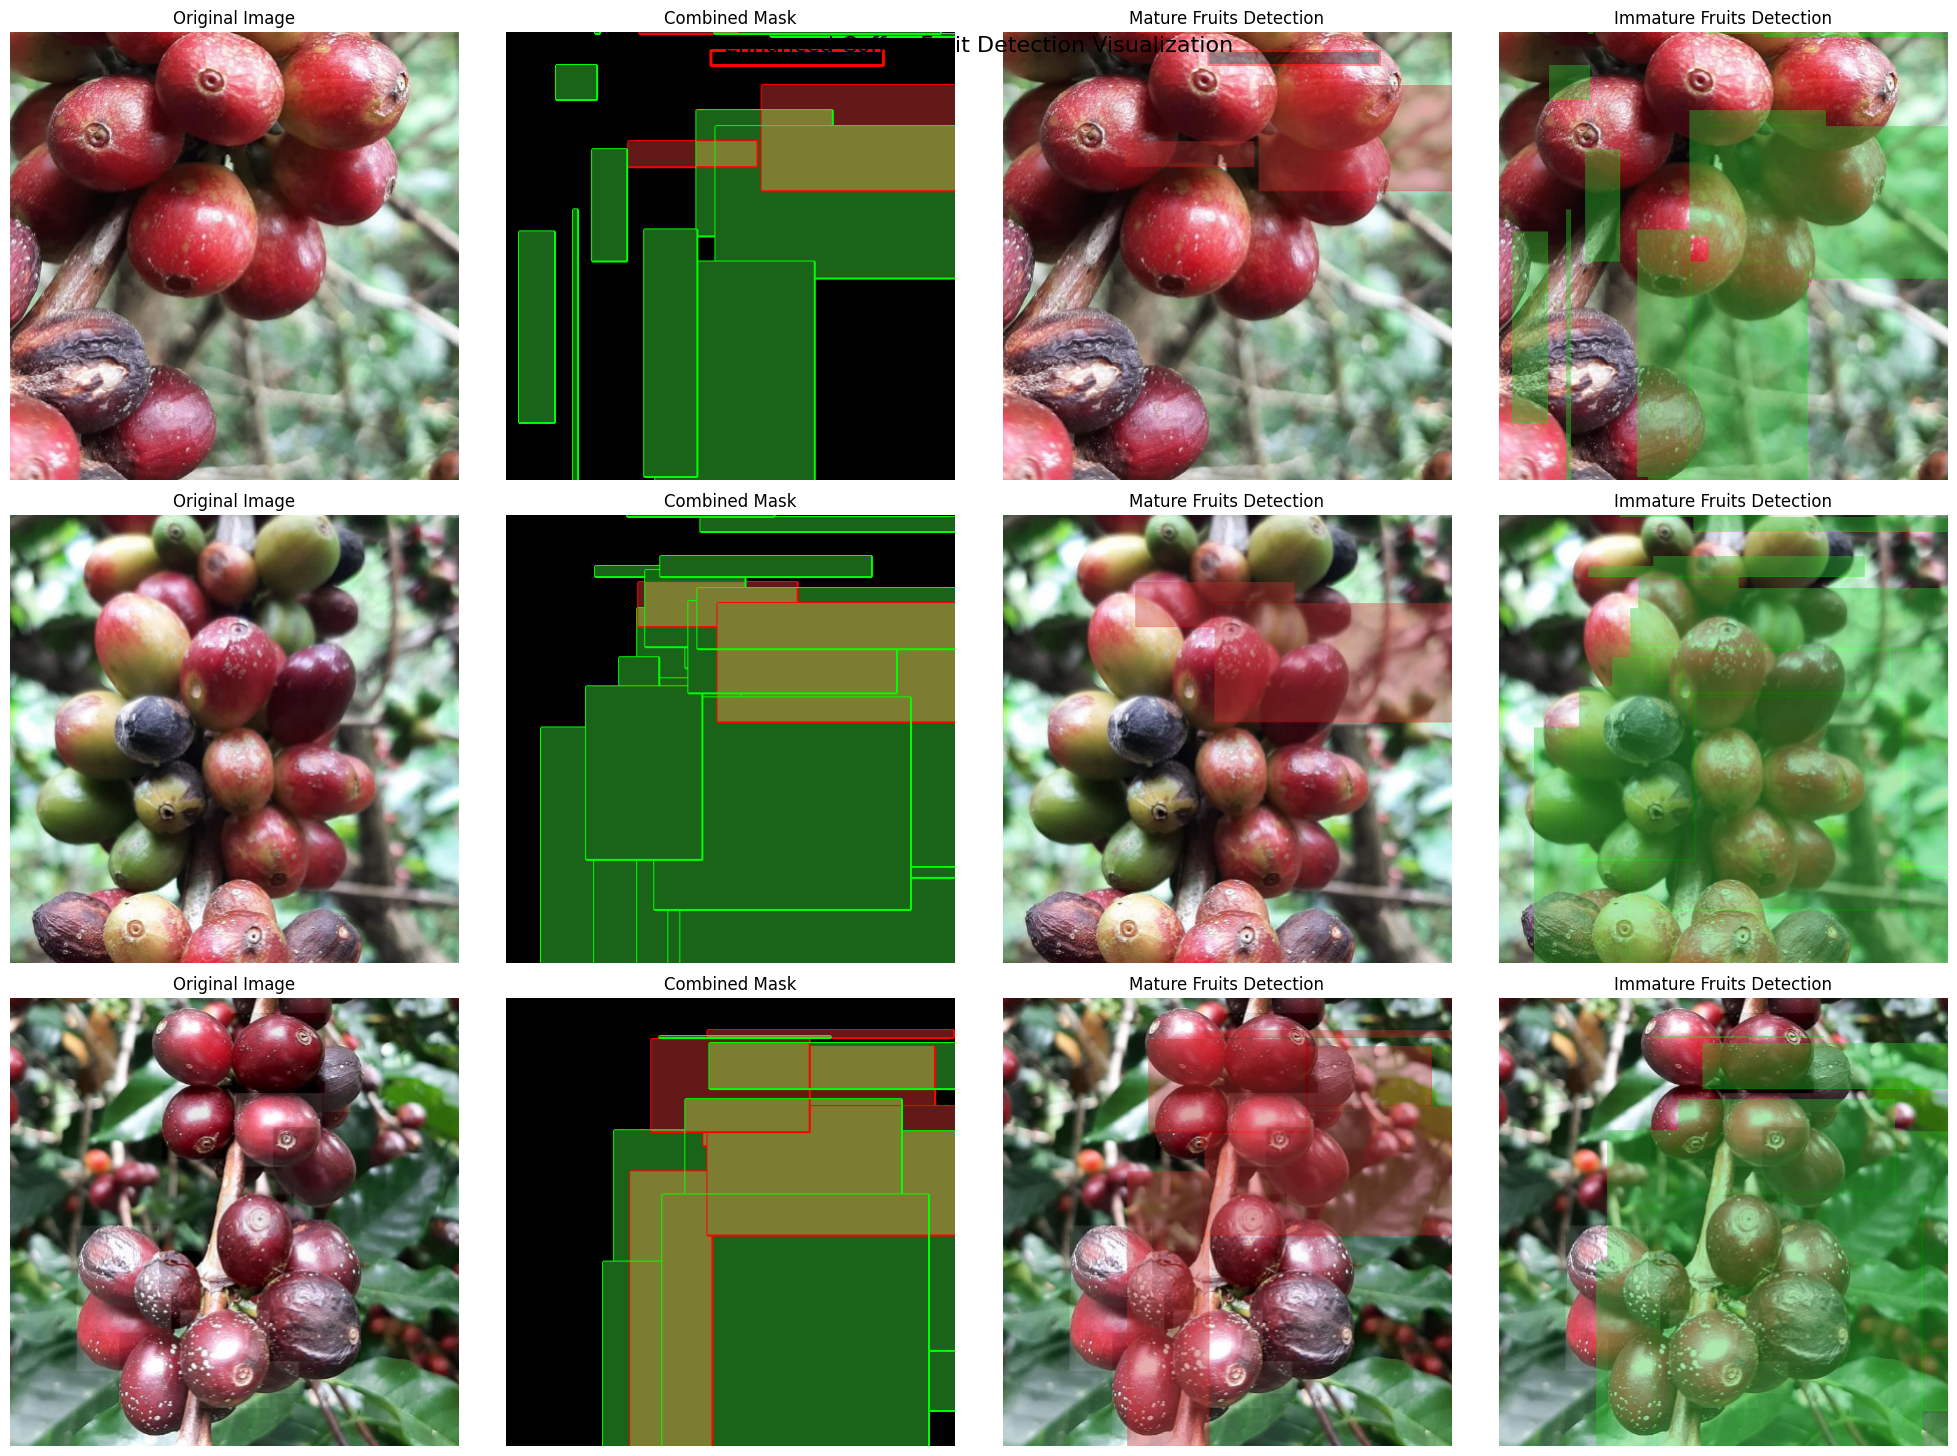

Enhanced visualization saved as: enhanced_coffee_fruit_masks_train.png


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from pathlib import Path
import random

# Define the data paths
data_paths = {
    'train': {
        'images': r"D:\YOLO8\Coffee Fruit detection.v1i.yolov8-obb (2)\Segmented_Classified_Dataset\train\images",
        'labels': r"D:\YOLO8\Coffee Fruit detection.v1i.yolov8-obb (2)\Segmented_Classified_Dataset\train\labels"
    },
    'test': {
        'images': r"D:\YOLO8\Coffee Fruit detection.v1i.yolov8-obb (2)\Segmented_Classified_Dataset\test\images",
        'labels': r"D:\YOLO8\Coffee Fruit detection.v1i.yolov8-obb (2)\Segmented_Classified_Dataset\test\labels"
    },
    'valid': {
        'images': r"D:\YOLO8\Coffee Fruit detection.v1i.yolov8-obb (2)\Segmented_Classified_Dataset\valid\images",
        'labels': r"D:\YOLO8\Coffee Fruit detection.v1i.yolov8-obb (2)\Segmented_Classified_Dataset\valid\labels"
    }
}

def create_enhanced_masks(img, label_file, img_size):
    """
    Create enhanced masks for mature and immature fruits with improved visibility
    """
    # Initialize masks with three channels for colored visualization
    mature_mask = np.zeros((*img_size, 3), dtype=np.uint8)
    immature_mask = np.zeros((*img_size, 3), dtype=np.uint8)
    
    # Create masks for filled regions
    mature_fill = np.zeros(img_size, dtype=np.uint8)
    immature_fill = np.zeros(img_size, dtype=np.uint8)
    
    if os.path.exists(label_file):
        with open(label_file) as f:
            for line in f:
                values = list(map(float, line.strip().split()))
                class_id, x, y, w, h = values[:5]
                x1 = int((x - w/2) * img_size[1])
                y1 = int((y - h/2) * img_size[0])
                x2 = int((x + w/2) * img_size[1])
                y2 = int((y + h/2) * img_size[0])
                
                # Add padding for better visibility
                padding = 2
                x1, y1 = max(0, x1-padding), max(0, y1-padding)
                x2, y2 = min(img_size[1], x2+padding), min(img_size[0], y2+padding)
                
                if class_id == 0:  # Mature fruit
                    cv2.rectangle(mature_fill, (x1, y1), (x2, y2), 255, -1)
                    cv2.rectangle(mature_mask, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    mature_mask[y1:y2, x1:x2] = [200, 50, 50]
                else:  # Immature fruit
                    cv2.rectangle(immature_fill, (x1, y1), (x2, y2), 255, -1)
                    cv2.rectangle(immature_mask, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    immature_mask[y1:y2, x1:x2] = [50, 200, 50]
    
    return mature_mask, immature_mask, mature_fill, immature_fill

def create_blended_visualization(img, mature_mask, immature_mask, mature_fill, immature_fill):
    """
    Create a blended visualization with enhanced contrast and visibility
    """
    mature_overlay = img.copy()
    immature_overlay = img.copy()
    
    alpha = 0.4  # Transparency factor
    
    mature_overlay[mature_fill > 0] = cv2.addWeighted(
        mature_overlay[mature_fill > 0], 1-alpha,
        mature_mask[mature_fill > 0], alpha, 0
    )
    
    immature_overlay[immature_fill > 0] = cv2.addWeighted(
        immature_overlay[immature_fill > 0], 1-alpha,
        immature_mask[immature_fill > 0], alpha, 0
    )
    
    combined_mask = np.zeros_like(img)
    combined_mask = cv2.addWeighted(mature_mask, 0.5, immature_mask, 0.5, 0)
    
    combined_mask[mature_mask.max(axis=2) == 255] = [255, 0, 0]
    combined_mask[immature_mask.max(axis=2) == 255] = [0, 255, 0]
    
    return mature_overlay, immature_overlay, combined_mask

def visualize_enhanced_samples(dataset_type='train', num_samples=3, img_size=(448, 448)):
    """
    Visualize samples with enhanced mask representation and higher resolution
    """
    img_dir = data_paths[dataset_type]['images']
    label_dir = data_paths[dataset_type]['labels']
    
    img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Filter for images that have both mature and immature fruits
    valid_samples = []
    for img_file in img_files:
        label_file = os.path.join(label_dir, os.path.splitext(img_file)[0] + '.txt')
        if os.path.exists(label_file):
            with open(label_file) as f:
                labels = [int(line.split()[0]) for line in f]
                if 0 in labels and 1 in labels:  # Has both mature and immature
                    valid_samples.append(img_file)
    
    selected_files = random.sample(valid_samples, min(num_samples, len(valid_samples)))
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('Enhanced Coffee Fruit Detection Visualization', fontsize=16, y=0.95)
    
    for idx, img_file in enumerate(selected_files):
        try:
            img_path = os.path.join(img_dir, img_file)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load image: {img_path}")
                continue
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            
            label_file = os.path.join(label_dir, os.path.splitext(img_file)[0] + '.txt')
            
            mature_mask, immature_mask, mature_fill, immature_fill = create_enhanced_masks(
                img, label_file, img_size
            )
            
            mature_overlay, immature_overlay, combined_mask = create_blended_visualization(
                img, mature_mask, immature_mask, mature_fill, immature_fill
            )
            
            axes[idx, 0].imshow(img)
            axes[idx, 0].set_title('Original Image')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(combined_mask)
            axes[idx, 1].set_title('Combined Mask')
            axes[idx, 1].axis('off')
            
            axes[idx, 2].imshow(mature_overlay)
            axes[idx, 2].set_title('Mature Fruits Detection')
            axes[idx, 2].axis('off')
            
            axes[idx, 3].imshow(immature_overlay)
            axes[idx, 3].set_title('Immature Fruits Detection')
            axes[idx, 3].axis('off')
            
        except Exception as e:
            print(f"Error processing image {img_file}: {str(e)}")
            continue
    
    plt.tight_layout()
    save_path = f'enhanced_coffee_fruit_masks_{dataset_type}.png'
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()
    print(f"Enhanced visualization saved as: {save_path}")

# Example usage
if __name__ == "__main__":
    # Visualize samples from the training set
    visualize_enhanced_samples(dataset_type='train', num_samples=3)